Everything needed to reproduce this work including this file itself and the 1-dimensional peridynamics code (which can be run in stand-alone mode as well) can be found in my [Github](https://github.com/johntfoster) repository.  To clone:

````bash
git clone git@github.com:johntfoster/1DPDpy.git
````

The user will need the Python modules `numpy`, `scipy`, and `matplotlib` installed to run `PD1D.py` and `ipython notebook` installed to reproduce this notebook.

# My Comments on the "patch test" for computational peridynamics

In Finite Element Analysis (FEA) it is common to check the validity of an element formulation as well as to verify a computational implementation with a simple test known as the "patch test".  The "patch test" is usually performed by creating a small group or "patch" of irregularly shaped elements, constraining only the rigid body modes, and applying a uniform displacement field at the boundaries.  The patch of elements passes the test if the nodal displacements match the *exact* solution, and the strain fields conform to the expected strain fields based on the element formulation.  For example, a patch test of constant strain plane elasticty elements should reproduce a constant strain field when a homogenous deformation is prescribed.

When considering a patch test for the common peridynamic strong-form particle integration scheme, the first thing to remember is that the solution to the peridynamic conservation of momentum equation *is not* the solution to the partial differential equatoin of the local theory.  It is also not the same solution as one would expect to get from a traditional FEA computation. Both <cite data-cite="silling2003dpb">(Silling et al., 2003)</cite> and <cite data-cite="weckner2009">(Weckner et al., 2009)</cite> have developed analytic solutions in 1D in the former and 3D in the later to very special classes of peridynamic problems and constitutive models.  The Figure below taken from <cite data-cite="weckner2009">(Weckner et al., 2009)</cite> shows a family of displacement field solutions for an infinite peridynamic bar under a self-equalibriating far-field body force distribution that converges to the classical local elasticity solution in the limit of $\delta \to 0$.
<br>
<img src="files/figs/weckner_disp.png" width="400">
<br>
<cite data-cite="bobaru2009convergence">(Bobaru et al., 2009)</cite> showed that 1D discrete solutions of the strong-form peridynamic momentum equation converge to analytic solutions of a bond-based peridynamic material.  This work also showed examples of adaptive and irregular discritizations.  Solutions to the peridynamic momentum equation show features not present in the classical theory, namely decaying oscillations in the displacement field and progressively weakening discontinuities that propagate outside of the loading region.  Therefore, a correct patch test of any discretized peridynamic solution would have to compare to an analytic solution given the same constitutive model.  Unfortunately, these analytic soluitons are near impossible for non-trivial constitutive models in two- and three-dimensions, and while possible, time consuming for formulate in one-dimension.  In this document what we will attempt to show will really be *consistancy* between state-based formulations and not a true patch test.

## Constitutive models
For reference, let's recall that the peridynamic conservation of momentum equation has the form

$$
\rho \mathbf{\ddot{u}}[\mathbf{x}] = \int_{\mathcal{H}} \underline{\mathbf{T}}[\mathbf{x}] - \underline{\mathbf{T}}[\mathbf{x'}] {\rm d}V_{\mathbf{x'}}
$$

where an explicit dependence on time has been suprressed in the equation and the consitutive response of the material is contained in the integrand.  The simplest form of a constitutive model that could be considered in peridynamics would be one in which the force in each *bond* pair of $\mathbf{x'}$ and $\mathbf{x}$ was independent of all others.  This is the so-called *bond-based* model that was introduced in the original paper on peridynamics <cite data-cite="silling2000ret">(Silling, 2000)</cite>.  An improvement to this model would be a model in which the force in each bond pair is influenced by the totality of deformations of all bonds.  If the resulting direction of action of such a force acts along the vector $\mathbf{x'}-\mathbf{x}$ it is called an *ordinary state-based* material.  An example of such a material model is

$$
\underline{\mathbf{T}} = \underline{t} \underline{\mathbf{M}}
$$

where $\underline{\mathbf{M}}$ is called a *unit vector-state* and is defined as unit vector pointing from the deformed position of $\mathbf{x}$ to the deformed position of $\mathbf{x'}$, and $\underline{t}$ is called a *force scalar-state*.  An example of a force scalar-state that has an equivalent elastic strain energy density to that of a local elasticity model. 

$$
\underline{t} = \frac{3 k \theta}{m} \underline{\omega} \, \underline{x} + \alpha \underline{\omega} \, \underline{e}^d
$$

Please refer to <cite data-cite="silling2007psa">(Silling et al., 2007)</cite> for meaning of the notation.  This type of state-based consitutive model will be refered to as a *linear peridynamic solid* or *LPS* constititive model in the sequal to distingish it from *correspondence* models.  Notice there are no derivatives appearing in this model.

### Correspondence models

As a convenience, there is a technique for incorporating classical stress-strain models into a peridynamic formulation by establishing an equivalence or correspondence of strain-energy density functionals.  It is important to note that this is still a non-local formulation and will only be *exactly* equivalent to the classical theory in the limit of vanishing horizon.  Omitting the details (refer to <cite data-cite="silling2007psa">(Silling et al., 2007)</cite> or <cite data-cite="foster2010visco">(Foster et al., 2010)</cite>) the correspondence formulation arrives at a force vector state

$$
\underline{\mathbf{T}} = \underline{\omega} \boldsymbol{\sigma}(\bar{\mathbf{F}}) \mathbf{K}^{-1} (\mathbf{x'-x})
$$

where $\boldsymbol{\sigma}$ is the First Piola-Kirchoff stress derived from an approximation of the deformation gradient $\bar{\mathbf{F}}$

$$
\bar{F}_{ij} = \int_\mathcal{H} (\mathbf{u[x'] - u[x] - x' + x})_{i} (\mathbf{x'-x})_{j} \rm{d}V_{\mathbf{x'}} K_{ij}^{-1} 
$$

and $\mathbf{K}$ is a *shape tensor* defined by

$$
K_{ij} = \int_\mathcal{H} (\mathbf{x'-x})_{i} (\mathbf{x'-x})_{j} \rm{d}V_{\mathbf{x'}}
$$

#### Mathematical convergence to the classical theory

We'll now show briefly that this model converges to the classical theory in the limit of vanishing horizon.  First, we assume a continuously differentialble stress field such that we can perform a Taylor expansion about the point $\mathbf{x'} = \mathbf{x}$, i.e.

$$
\sigma_{ij}[\mathbf{x'}] = \sigma_{ij}[\mathbf{x}] + \frac{\partial \sigma_{ij}[\mathbf{x}]}{\partial x_k} \xi_k + \mathcal{O}(||\boldsymbol{\xi}||^2)
$$

where $\boldsymbol{\xi} = \mathbf{x'-x}$.  Substituting this into the force-state relationship and back into the equation of motion (in the absence of body forces) we have

$$
\begin{aligned}
\rho \ddot{u}_i[\mathbf{x}] =& \int_\mathcal{H} \underline{\omega} \sigma_{ij}[\mathbf{x}] K_{jl}^{-1} \xi_l + \underline{\omega} \left[ \sigma_{ij}[\mathbf{x}] + \frac{\partial \sigma_{ij}[\mathbf{x}]}{\partial x_k} \xi_k + \mathcal{O}(||\boldsymbol{\xi}||^2) \right] K_{jl}^{-1} \xi_l {\rm d}V_{\mathbf{x'}} \\
=& 2 \int_\mathcal{H} \underline{\omega} \sigma_{ij}[\mathbf{x}] K_{jl}^{-1}  \xi_l {\rm d}V_{\mathbf{x'}} + \int_\mathcal{H} \underline{\omega} \left[\frac{\partial \sigma_{ij}[\mathbf{x}]}{\partial x_k} \xi_k + \mathcal{O}(||\boldsymbol{\xi}||^2) \right] K_{jl}^{-1} \xi_l {\rm d}V_{\mathbf{x'}} \\
=&  \frac{\partial \sigma_{ij}[\mathbf{x}]}{\partial x_k} K_{jl}^{-1} \int_\mathcal{H}  \underline{\omega}\xi_l \xi_k  {\rm d}V_{\mathbf{x'}} + \mathcal{O}(\delta) \\
=&  \frac{\partial \sigma_{ij}[\mathbf{x}]}{\partial x_k} K_{jl}^{-1} K_{lk} + \mathcal{O}(\delta) \\
=&  \frac{\partial \sigma_{ij}[\mathbf{x}]}{\partial x_k} \delta_{jk} + \mathcal{O}(\delta) \\
=&  \frac{\partial \sigma_{ij}[\mathbf{x}]}{\partial x_j} + \mathcal{O}(\delta) \\
\end{aligned}
$$

where we've made use of the antisymmetry in the integrand to eliminate the first term between the second and third step above.  Now we take $\delta \to 0$

$$
\begin{aligned}
\lim_{\delta \to 0} \lbrace \rho \ddot{u}_i[\mathbf{x}] =&  \frac{\partial \sigma_{ij}[\mathbf{x}]}{\partial x_j} + \mathcal{O}(\delta) \rbrace \\
 \rho \ddot{u}_i[\mathbf{x}] =&  \frac{\partial \sigma_{ij}[\mathbf{x}]}{\partial x_j} \\
  \rho \ddot{\mathbf{u}}[\mathbf{x}] =&  \nabla \cdot \boldsymbol{\sigma}[\mathbf{x}]
\end{aligned}
$$

thus establishing the convergence mathematically.

# Numerical Examples

We'll start by importing the class that defines a 1-dimensional peridynamic problem.


In [48]:
from PD1D import PD_Problem

Now we instantiate the problem using the LPS constititive model defined in the last section.

In [49]:
fixed_length = 40
delta_x = 0.5
fixed_horizon = 3.5 * delta_x

problem1 = PD_Problem(bar_length=fixed_length, number_of_elements=(fixed_length/delta_x), 
                      horizon=fixed_horizon, constitutive_model_flag='LPS', randomization_factor=0.0)

Solve the problem and get the solution vectors for plotting.

In [50]:
problem1.solve(prescribed_displacement=0.0001)
disp1 = problem1.get_solution()
nodes1 = problem1.get_nodes()

Now plot the results

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

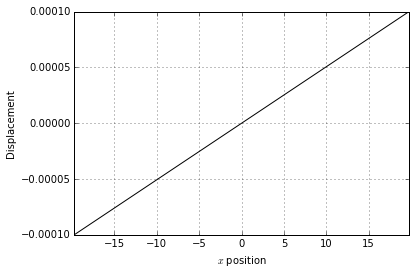

In [52]:
plt.plot(nodes1, disp1, 'k-');
plt.grid(b=True);
plt.axis('tight');
plt.ylabel('Displacement');
plt.xlabel('$x$ position');

We can also get the deformation gradient and plot it as well.  Note that the deformation gradient is not used in the constitutive model in any way.  It is post processed and plotted here for comparison.

(0.99, 1.01)

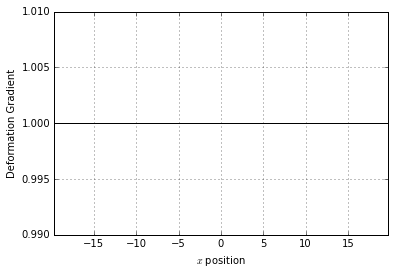

In [72]:
def_grad1 = problem1.get_deformation_gradient()
plt.plot(nodes1, def_grad1, 'k-');
plt.grid(b=True);
plt.axis('tight');
plt.ylabel('Deformation Gradient');
plt.xlabel('$x$ position');
plt.ylim([0.99,1.01])

Now we will repeat the steps above, this time using a random purtabation of 30% to the interior nodes.  The nodes near the boundaries are not purturbed in any way to preserve consistant application of the boundary conditions.

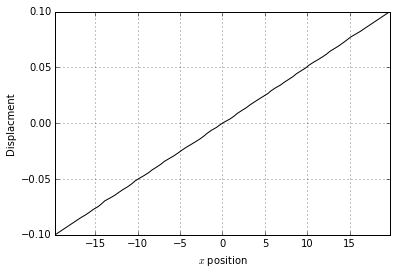

In [54]:
fixed_length = 40
delta_x = 0.5
fixed_horizon = 3.5 * delta_x

problem2 = PD_Problem(bar_length=fixed_length, number_of_elements=(fixed_length/delta_x), 
                      horizon=fixed_horizon, constitutive_model_flag='LPS', randomization_factor=0.3)
problem2.solve(prescribed_displacement=0.1)
disp2 = problem2.get_solution()
nodes2 = problem2.get_nodes()
plt.plot(nodes2, disp2, 'k-');
plt.grid(b=True);
plt.axis('tight');
plt.ylabel('Displacment');
plt.xlabel('$x$ position');

Note the very small oscilations in the displacement field.  Just to verify below we plot the node volumes to show the randomness.

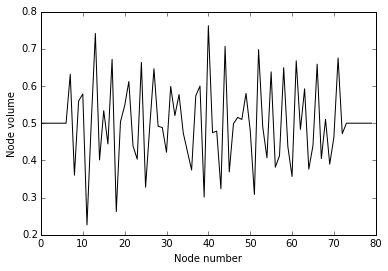

In [55]:
plt.plot(range(len(nodes2)), problem2.lengths, 'k-');
plt.ylabel('Node volume');
plt.xlabel('Node number');

As expected from the small oscilations in the displacement field, here we see them as well in the deformation gradient.

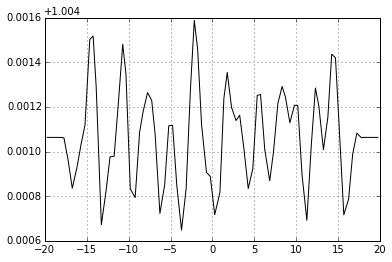

In [64]:
def_grad2 = problem2.get_deformation_gradient()
plt.plot(nodes2, def_grad2, 'k-');
plt.grid(b=True);
plt.axis();

Moving on the *corresondence* models, we repeat the steps above.  First for an equally spaced grid.

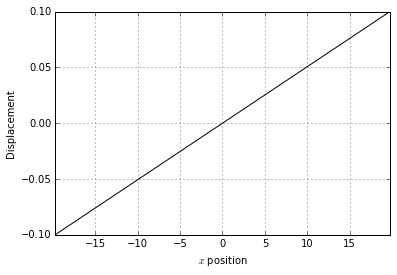

In [57]:
fixed_length = 40
delta_x = 0.5
fixed_horizon = 3.5 * delta_x

problem3 = PD_Problem(bar_length=fixed_length, number_of_elements=(fixed_length/delta_x), 
                      horizon=fixed_horizon, constitutive_model_flag='correspondence', randomization_factor=0.0)
problem3.solve(prescribed_displacement=0.1)
disp3 = problem3.get_solution()
nodes3 = problem3.get_nodes()
plt.plot(nodes3, disp3, 'k-');
plt.grid(b=True);
plt.axis('tight');
plt.xlabel('$x$ position');
plt.ylabel('Displacement');

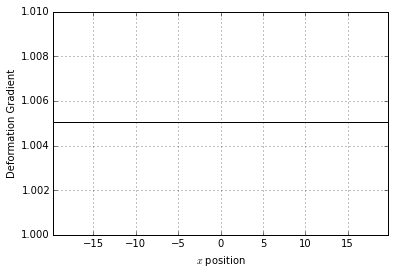

In [75]:
def_grad3 = problem3.get_deformation_gradient()
plt.plot(nodes3, def_grad3, 'k-');
plt.grid(b=True);
plt.axis('tight');
plt.xlabel('$x$ position');
plt.ylabel('Deformation Gradient');
plt.ylim([1.0,1.01]);

Now a randomly purturbed grid.

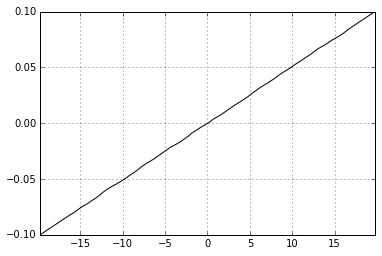

In [59]:
fixed_length = 40
delta_x = 0.5
fixed_horizon = 3.5 * delta_x

problem4 = PD_Problem(bar_length=fixed_length, number_of_elements=(fixed_length/delta_x), 
                      horizon=fixed_horizon, constitutive_model_flag='correspondence', randomization_factor=0.3)
problem4.solve(prescribed_displacement=0.1)
disp4 = problem4.get_solution()
nodes4 = problem4.get_nodes()
plt.plot(nodes4, disp4, 'k-');
plt.grid(b=True);
plt.axis('tight');

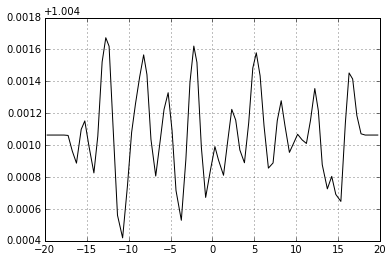

In [60]:
def_grad4 = problem4.get_deformation_gradient()
plt.plot(nodes4, def_grad4, 'k-');
plt.grid(b=True);
plt.axis();

To summarize

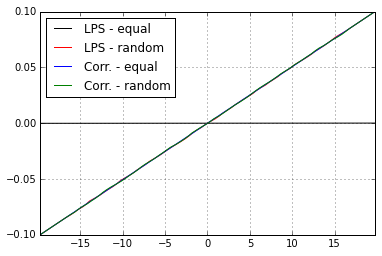

In [61]:
plt.plot(nodes1, disp1, 'k-', label='LPS - equal')
plt.plot(nodes2, disp2, 'r-', label='LPS - random')
plt.plot(nodes3, disp3, 'b-', label='Corr. - equal')
plt.plot(nodes4, disp4, 'g-', label='Corr. - random')
plt.legend(loc='upper left')
plt.grid(b=True);
plt.axis('tight');
plt.show()

It appears that there is a similar result for both the LPS and *correspondence* models.  This is all I have time for now, I appreciate comments.